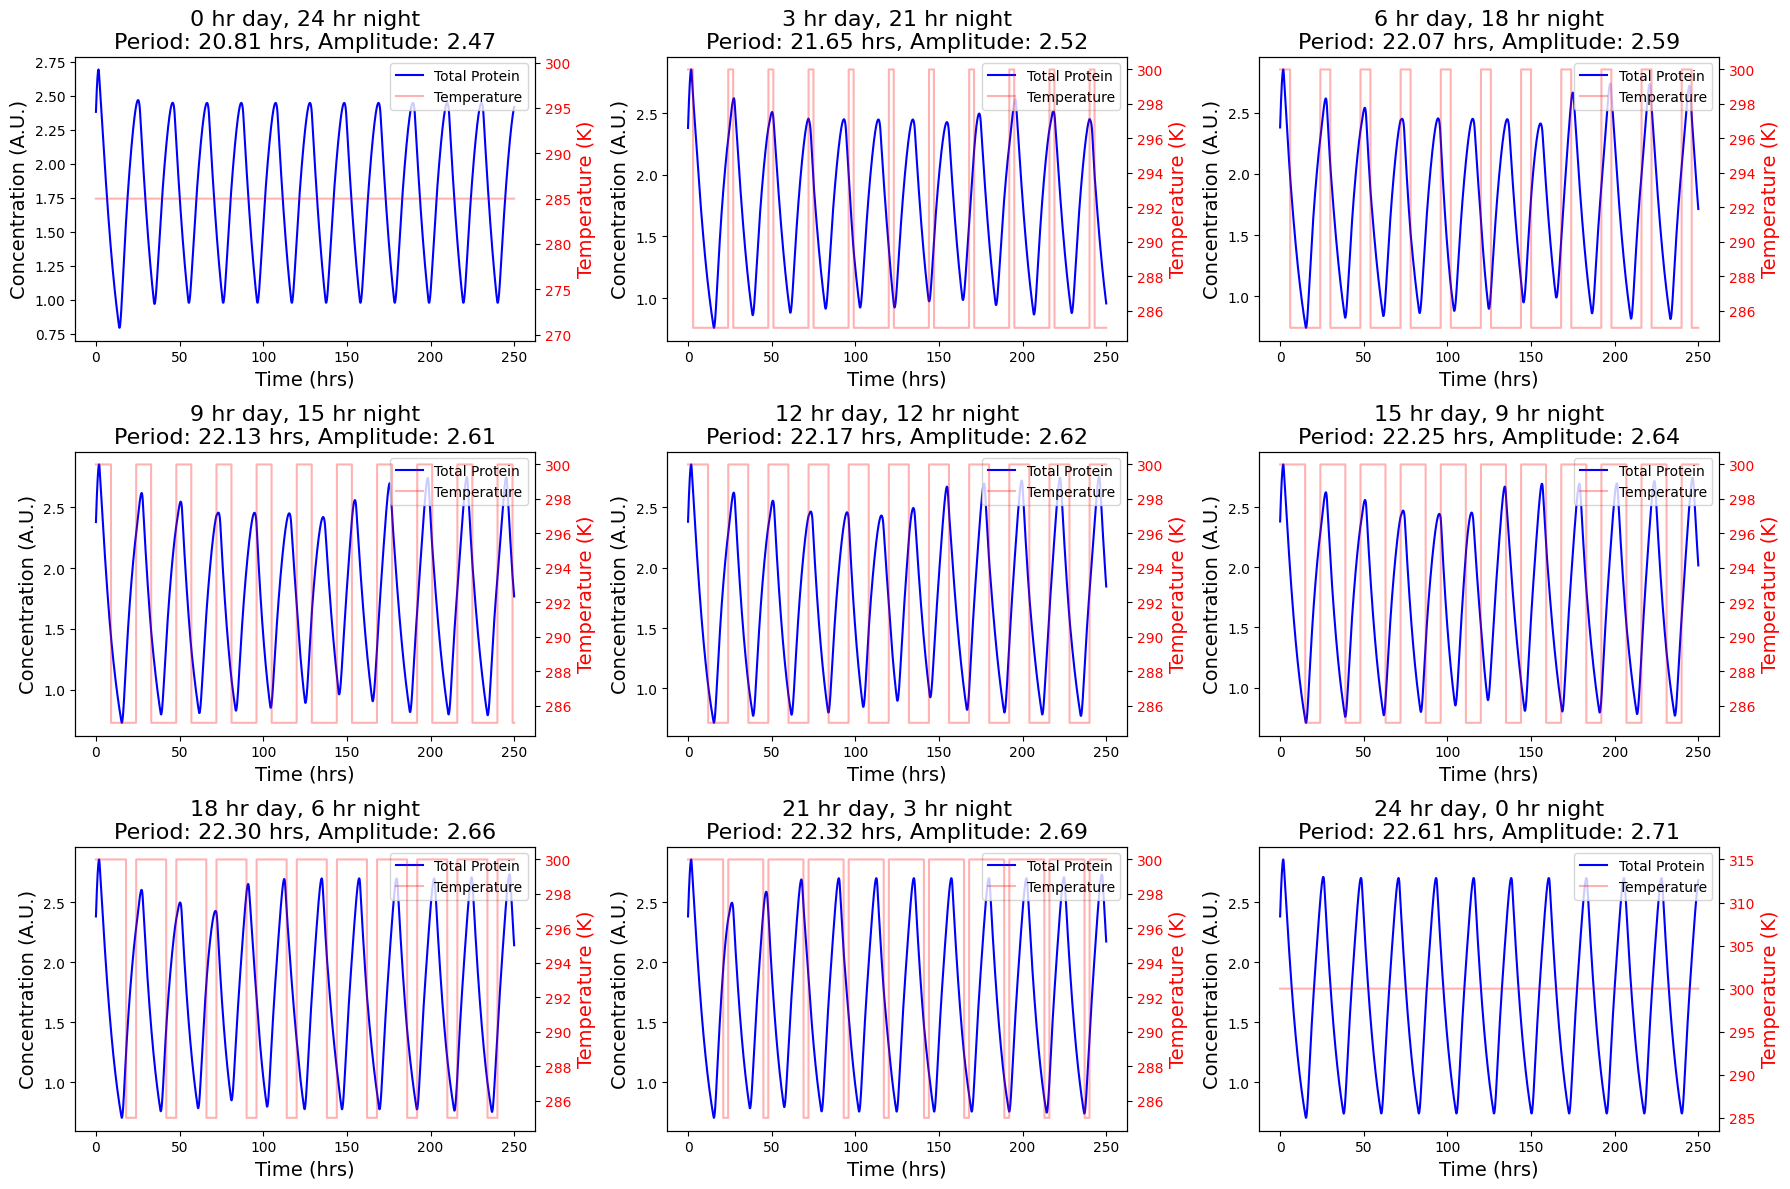

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def kaiABC_Rust(c, t, Temp):
    T = c[0]
    ST = c[1]
    S = c[2]

    KaiA = 1.3
    x = 298.15  # Temperature used for insensitive reactions

    # Parameters
    khalf = 383.83 * np.exp(-(16.8330449e3) / (8.3144598 * Temp))
    
    kUT0 = 0.0
    kUTA = 383.83 * np.exp(-(16.56527851e3) / (8.3144598 * Temp))
   
    kDT0 = 0.0
    kDTA = 383.83 * np.exp(-(19.08885839e3) / (8.3144598 * Temp))
   
    kTU0 = 383.83 * np.exp(-(18.60866545e3) / (8.3144598 * Temp))
    kTUA = 383.83 * np.exp(-(21.0046209e3) / (8.3144598 * Temp))
    
    kTD0 = 0.0
    kTDA = 383.83 * np.exp(-(18.5744178e3) / (8.3144598 * Temp))
   
    kSD0 = 0.0
    kSDA = 383.83 * np.exp(-(16.43132499e3) / (8.3144598 * Temp))
    
    kDS0 = 383.83 * np.exp(-(17.64373845e3) / (8.3144598 * x))
    kDSA = 383.83 * (-np.exp(-(17.56984493e3) / (8.3144598 * Temp)))
    
    kUS0 = 0.0
    kUSA = 383.83 * np.exp(-(22.00905957e3) / (8.3144598 * Temp))
    
    kSU0 = 383.83 * np.exp(-(20.21073081e3) / (8.3144598 * x))
    kSUA = 383.83 * (-np.exp(-(19.73888331e3) / (8.3144598 * Temp)))
    
    KaiC = 3.4

    U = max(0, KaiC - T - ST - S)
    A = max(0, 1.3 - 2. * S)

    # Parameters defined as function
    kUT = kUT0 + ((kUTA * A) / (khalf + A))
    kDT = kDT0 + ((kDTA * A) / (khalf + A))
    kTU = kTU0 + ((kTUA * A) / (khalf + A))
    kTD = kTD0 + ((kTDA * A) / (khalf + A))
    kSD = kSD0 + ((kSDA * A) / (khalf + A))
    kDS = kDS0 + ((kDSA * A) / (khalf + A))
    kUS = kUS0 + ((kUSA * A) / (khalf + A))
    kSU = kSU0 + ((kSUA * A) / (khalf + A))
    
    # Differential equations
    dTdt = (kUT * U + kDT * ST - kTU * T - kTD * T)
    dSTdt = (kTD * T + kSD * ST - kDT * ST - kDS * ST)
    dSdt = (kUS * U + kDS * ST - kSU * S - kSD * S)
    
    return [dTdt, dSTdt, dSdt]

def simulate_temp_cycle(t, day_temp, night_temp, day_length, night_length):
    temp_cycle = np.zeros_like(t)
    cycle_length = day_length + night_length

    for i, time in enumerate(t):
        cycle_time = time % cycle_length
        if cycle_time < day_length:
            temp_cycle[i] = day_temp
        else:
            temp_cycle[i] = night_temp

    return temp_cycle

def analyze_oscillator_with_temp_cycle(day_length, night_length, total_time=250, css=[0.68, 1.36, 0.34]):
    t0 = 0
    tspan = np.arange(t0, total_time, 0.02)

    # Define temperature cycle
    day_temp = 300
    night_temp = 285
    temp_cycle = simulate_temp_cycle(tspan, day_temp, night_temp, day_length, night_length)

    # Define a function that incorporates the temperature cycle
    def kaiABC_Rust_temp_cycle(c, t):
        Temp = np.interp(t, tspan, temp_cycle)
        return kaiABC_Rust(c, t, Temp)

    sol = odeint(kaiABC_Rust_temp_cycle, css, tspan)
    T_val = sol[:, 0]
    ST_val = sol[:, 1]
    S_val = sol[:, 2]

    # Calculate total protein concentration over time
    total_protein = T_val + ST_val + S_val

    # Analyzing the amplitude and period of the total protein
    peaks, _ = find_peaks(total_protein)
    amplitudes = total_protein[peaks]

    if len(peaks) > 1:
        periods = np.diff(tspan[peaks])
        mean_period = np.mean(periods)
        mean_amplitude = np.mean(amplitudes)
    else:
        mean_period = np.nan
        mean_amplitude = np.nan

    return tspan, total_protein, temp_cycle, mean_period, mean_amplitude

# Define day and night lengths for different conditions
conditions = [
    (0, 24),  # 0 hr day, 24 hr night
    (3, 21),  # 3 hr day, 21 hr night
    (6, 18),  # 6 hr day, 18 hr night
    (9, 15),  # 9 hr day, 15 hr night
    (12, 12), # 12 hr day, 12 hr night
    (15, 9),  # 15 hr day, 9 hr night
    (18, 6),  # 18 hr day, 6 hr night
    (21, 3),  # 21 hr day, 3 hr night
    (24, 0)   # 24 hr day, 0 hr night
]

# Plotting results for each condition
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (day_length, night_length) in enumerate(conditions):
    tspan, total_protein, temp_cycle, mean_period, mean_amplitude = analyze_oscillator_with_temp_cycle(day_length, night_length)
    
    ax1 = axs[i]
    ax2 = ax1.twinx()
    
    ax1.plot(tspan, total_protein, 'b-', label='Total Protein')
    ax2.plot(tspan, temp_cycle, 'r-', alpha=0.3, label='Temperature')
    
    ax1.set_xlabel('Time (hrs)', fontsize=14)
    ax1.set_ylabel('Concentration (A.U.)', fontsize=14)
    ax2.set_ylabel('Temperature (K)', fontsize=14, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_title(f'{day_length} hr day, {night_length} hr night\nPeriod: {mean_period:.2f} hrs, Amplitude: {mean_amplitude:.2f}', fontsize=16)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()
